In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
%matplotlib inline

import datetime
import math
import os


from IPython.display import display

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tools.eval_measures import rmse

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.model_selection import KFold, cross_val_score, train_test_split

import warnings
warnings.filterwarnings("ignore")

## Load and View Data

In [29]:
def load_data(csv_path:str, usecols:list=None) -> pd.DataFrame:
    data = pd.read_csv(csv_path)
    data.columns = data.columns.str.lower()
    
    if usecols:
        usecols += ["date"]
        data = data[set(usecols)]
    
    return data

def resample_data_freq(data:pd.DataFrame, freq:str, target_col) -> pd.DataFrame:
    data = data.copy()
    
    data.date = pd.to_datetime(data.date)
    data.set_index(["date"], inplace=True)
    data = data.resample(rule=freq).sum()
    
    data = data[data[target_col] != 0.0]
    
    data.reset_index(inplace=True)
    return data
    
    
target_col = "total"
freq = "D"
csv_path = "supermarket_sales - Sheet1.csv"
lags = 13
test_ratio = 12


sales_data = load_data(csv_path=csv_path, usecols=[target_col])
freq_data = resample_data_freq(data=sales_data, target_col=target_col, freq=freq)

In [30]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1000 non-null   object 
 1   total   1000 non-null   float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


In [31]:
display(sales_data.head())
freq_data.head()

,date,total
0,1/5/2019,548.9715
1,3/8/2019,80.2200
2,3/3/2019,340.5255
3,1/27/2019,489.0480
4,2/8/2019,634.3785


,date,total
0,2019-01-01,4745.1810
1,2019-01-02,1945.5030
2,2019-01-03,2078.1285
3,2019-01-04,1623.6885
4,2019-01-05,3536.6835


# EDA

In [32]:
# Duration of dataset
def sales_duration(data):
    data.date = pd.to_datetime(data.date)
    number_of_days = data.date.max() - data.date.min()
    number_of_years = round(number_of_days.days / 365)
    number_of_months = round(number_of_days.days / 30)
    numver_of_weeks = round(number_of_days.days / 7)
    
    print(number_of_days.days, 'days')
    print(numver_of_weeks, 'weeks')
    print(number_of_months, 'months')
    print(number_of_years, 'years')
    
sales_duration(data=sales_data)

88 days
13 weeks
3 months
0 years


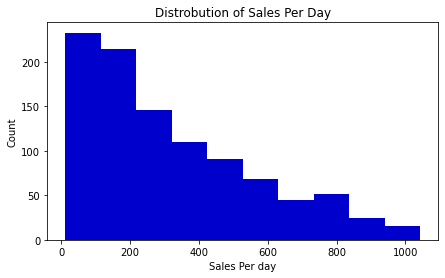

In [33]:
def sales_per_day(data, target_col, period):
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(data[target_col], color='mediumblue')
    
    ax.set(xlabel = f"Sales Per {period}", ylabel = "Count", title = f"Distrobution of Sales Per {period.title()}")
    
sales_per_day(data=sales_data, target_col=target_col, period="day")

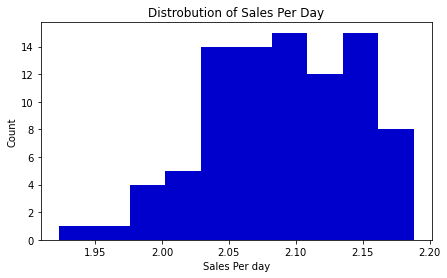

In [37]:
freq_data[target_col] = np.log(freq_data[target_col])
sales_per_day(data=freq_data, target_col=target_col, period="day")

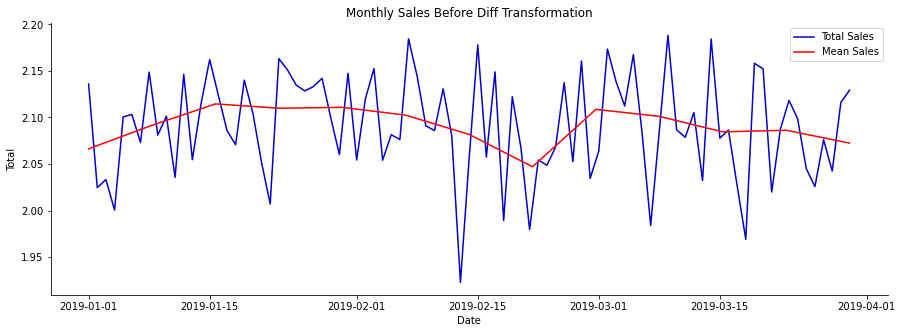

In [38]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Sales')
    
    if y_col.replace("_diff", "") == "total":
        second = data.groupby(data.date.dt.week)[y_col].mean().reset_index()
        second.date = pd.date_range(start=data.date.min(), end=data.date.max(), periods=13)
        sns.lineplot((second.date + datetime.timedelta(0*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    else:
        second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
        second.date = pd.to_datetime(second.date, format='%Y')
        sns.lineplot((second.date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    
    
    ax.set(xlabel = "Date", ylabel = f"{y_col.title()}", title = title)
    sns.despine()
    
time_plot(freq_data, 'date', target_col, 'Monthly Sales Before Diff Transformation')

## Stationary Test

In [39]:
# check stationary
from statsmodels.tsa.stattools import adfuller

df_test = adfuller(freq_data[target_col], autolag="AIC")

print("1. ADF : ", df_test[0])
print("2. P-value : ", df_test[1])
print("3. Num of lags : ", df_test[2])
print("4. Num of obs used for ADF reg and critical values calc : ", df_test[3])
print("5. Critical value : ", df_test[4])

for key, val in df_test[4].items():
    print("\t", key, " : ", val)

1. ADF :  -7.465264550440819
2. P-value :  5.22473894135959e-11
3. Num of lags :  1
4. Num of obs used for ADF reg and critical values calc :  87
5. Critical value :  {'1%': -3.5078527246648834, '5%': -2.895382030636155, '10%': -2.584823877658872}
	 1%  :  -3.5078527246648834
	 5%  :  -2.895382030636155
	 10%  :  -2.584823877658872


In [40]:
# freq_data[target_col] = np.log(freq_data[target_col])
# display(freq_data.head())

# sales_per_day(data=freq_data, target_col=target_col, period="day")

In [41]:
freq_data["timestamp"] = pd.to_datetime(freq_data["date"]).astype(int) // (10**9)
freq_data.drop(["date"], axis=1, inplace=True)

freq_data.head()

,total,timestamp
0,2.135926,1546300800
1,2.024626,1546387200
2,2.033296,1546473600
3,2.000460,1546560000
4,2.100585,1546646400


In [42]:
dataset = freq_data.values
X = dataset[:, 1].reshape(-1, 1)
Y = dataset[:, 0:1]

print(X.shape, Y.shape)

validation_size = 0.15
seed = 7

X_train, X_validation, y_train, y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

(89, 1) (89, 1)


((75, 1), (75, 1), (14, 1), (14, 1))

In [43]:
num_folds = 10
scoring = "r2"

# Spot-Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [44]:
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=False)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    
    # result
    results.append(cv_results)
    names.append(name)
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.361766 (0.621545)
LASSO: -0.361765 (0.621541)
EN: -0.361766 (0.621543)
KNN: -0.911229 (0.993492)
CART: -2.554236 (2.949351)
SVR: -0.430405 (0.473172)


R2 sq:  0.7864207266420976
Mean squared error: 0.00
Test Variance score: 0.15


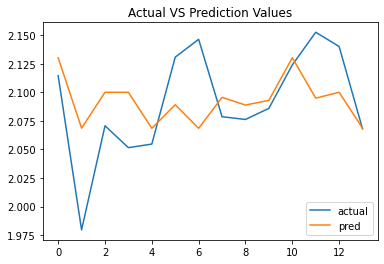

,actual,pred
0,2.114527,2.130240
1,1.979586,2.068623
2,2.070701,2.100005
3,2.051547,2.100005
4,2.054679,2.068459
5,2.130747,2.089127
6,2.146338,2.068459
7,2.078612,2.095594
8,2.076228,2.088815
9,2.085958,2.092961


In [73]:
from sklearn import ensemble
# Fit regression model
params = {'n_estimators': 67, 'max_depth': 2, 'min_samples_split': 2, 'learning_rate': 0.2, 'loss': 'ls'}
model = ensemble.GradientBoostingRegressor(**params)
model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, r2_score
model_score = model.score(X_train, y_train)
# Have a look at R sq to give an idea of the fit ,
# Explained variance score: 1 is perfect prediction
print('R2 sq: ', model_score)
y_predicted = model.predict(X_validation)

# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(y_validation, y_predicted))
# Explained variance score: 1 is perfect prediction
print('Test Variance score: %.2f' % r2_score(y_validation, y_predicted))

dataframe = pd.DataFrame(np.concatenate([y_validation, y_predicted.reshape(-1, 1)], axis=1), columns=["actual", "pred"])

dataframe.plot()
plt.title("Actual VS Prediction Values")
plt.legend()
plt.show()

display(dataframe)